In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: ROICaT
python version: 3.9.13


# Intro: Types of data
This notebook will demonstrate how to import data of various types into a data object which can be used for classification or tracking.\
There are 5 types of data that are possible to collect into a data class:

### 1. **ROI spatial footprints**: 
- The mask of an ROI in the full field of view.
- Used for **tracking only**.
- Stored as sparse arrays.

### 2. **ROI images**: 
- Images of individual masks. 
- Used for **tracking AND classifiaction**.
- Stored as dense arrays.

### 3. **ROI class labels**: 
- Labels of the classification of each ROI. 
- Used for **classification only**.
- Stored as integer arrays.

### 4. **Field of view (FOV) images**:
- Images of the average field of view of the imaging plane.
- Used for **tracking only**.
- Stored as dense arrays.

### 5. **Resolution**:
- In um / pixel
- Used for **tracking and classification**
- Stored as attributes in the data class.

___

# Demo: Classification
Make a custom data object with ROI images and labels.\
For classification, 3 key data elements are needed:
1. ROI images
2. ROI class labels
3. Image resolution in um/pixel

### Import custom ROI_images and associated labels

In [2]:
%load_ext autoreload
%autoreload 2

import roicat

In [3]:
from pathlib import Path

import numpy as np
import scipy.sparse
import einops

### Load ROI_images data and labels data

Load some custom data of ROI images that are stored as a sparse array.\
The sparse array is a 2D sparse matrix with `shape = (n_ROIs, height*width)`

In [4]:
data_ROI_images = scipy.sparse.load_npz(str(Path(r'/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/ShihYi labeled_cells_for_Rich/sf_concat_rs_sparse.npz').resolve()))
shape_ROI = (36,36)

ROI_images_array = einops.rearrange(
    tensor=data_ROI_images.toarray(), 
    pattern='n_ROIs (height width) -> n_ROIs height width', 
    **{'height': shape_ROI[0], 'width': shape_ROI[1]}
)

Load associated labels with the above ROI images.\
These labels are stored as a list of 1-D numpy arrays. Class labels are defined as integers (0-n_classes).

In [5]:
data_classLabels = np.load(str(Path(r'/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/ShihYi labeled_cells_for_Rich/labels.npy').resolve())).astype(int)

Specify the `um_per_pixel`

In [6]:
um_per_pixel = 2.0

### Make data class with ROI_images and class_labels attributes

In [7]:
data = roicat.data_importing.Data_roicat(verbose=True)

data.set_ROI_images(
    ROI_images=[ROI_images_array],
    um_per_pixel=1.5,
)

data.set_class_labels(class_labels=[data_classLabels])

Starting: Importing ROI images
Completed: Imported 1 sessions. Each session has [68382] ROIs. Total number of ROIs is 68382. The um_per_pixel is 1.5 um per pixel.
Starting: Importing class labels
Labels and ROI Images match in shapes: Class labels and ROI images have the same number of sessions and the same number of ROIs in each session.
Completed: Imported labels for 1 sessions. Each session has [68382] class labels. Total number of class labels is 68382.


Check to see what pipeline applications the data object is capable of running with the data it has

In [8]:
data.check_completeness(verbose=True);

RH WARNING: Tracking incomplete because following attributes are missing: ['spatialFootprints', 'FOV_images']
Labels and ROI Images match in shapes: Class labels and ROI images have the same number of sessions and the same number of ROIs in each session.
Cannot check validity of spatialFootprints and FOV_images because one or both do not exist as attributes.
Data_roicat object completeness: {'classification_inference': True, 'classification_training': True, 'tracking': False}


check out the data class' `.__repr__()` method

In [9]:
print(data)

Data_roicat object: {'n_sessions': 1, 'n_roi': [68382], 'n_roi_total': 68382, 'um_per_pixel': 1.5, 'n_classes': 4, 'n_class_labels': [68382], 'n_class_labels_total': 68382, 'unique_class_labels': array([1, 2, 3, 4])}.


### Demonstrate saving and loading
The `.save` and `.load` methods allow for saving of a pickled object to disk

In [10]:
data.save('/home/rich/Desktop/test_obj.pkl', allow_overwrite=True)

data = roicat.data_importing.Data_roicat(verbose=True)
data.load('/home/rich/Desktop/test_obj.pkl')
print(data)

Saved Data_roicat as a pickled object to /home/rich/Desktop/test_obj.pkl.
Loaded Data_roicat object from /home/rich/Desktop/test_obj.pkl.
Data_roicat object: {'n_sessions': 1, 'n_roi': [68382], 'n_roi_total': 68382, 'um_per_pixel': 1.5, 'n_classes': 4, 'n_class_labels': [68382], 'n_class_labels_total': 68382, 'unique_class_labels': array([1, 2, 3, 4])}.


# Demo: Tracking
Make a custom data object with Spatial Footprints and related metadata.\
For tracking, 3 key data elements are needed:
1. ROI spatial footprints (image of ROI in the entire field of view)
2. ROI images (small centered images of each ROI)
3. Field of view images
4. Image resolution in um/pixel

### Download and load some example data
This data is kindly donated from Noah Pettit and was obtained while in Christopher Harvey's lab at Harvard Medical School.\
Note the fields in the dictionary.

In [10]:
directory_save = r'/home/rich/Desktop/'

path_save = str(Path(directory_save) / 'test_spatialFootprints.npz')
roicat.helpers.download_file(
    url='https://osf.io/qgazx/download',
    path_save=path_save,
);

files_spatialFootprints = np.load(path_save, allow_pickle=True)['arr_0'][()]

print(files_spatialFootprints.keys())

File already exists locally: /home/rich/Desktop/test_spatialFootprints.npz
dict_keys(['sf', 'FOV_height', 'FOV_width', 'FOV_images', 'um_per_pixel'])


The spatialFootprints data consists of a list of sparse arrays. Each array is of shape: `(n_roi, FOV_height * FOV_width)`. The FOV is 512 x 512 pixels. Each row of the array is a flattened ROI image, where reshaping is done with order='C'.\
This is the format that the `Data_roicat` class holds the spatial footprints in.

In [11]:
display(files_spatialFootprints['sf'])

[<508x262144 sparse matrix of type '<class 'numpy.float32'>'
 	with 80614 stored elements in Compressed Sparse Row format>,
 <420x262144 sparse matrix of type '<class 'numpy.float32'>'
 	with 67079 stored elements in Compressed Sparse Row format>,
 <539x262144 sparse matrix of type '<class 'numpy.float32'>'
 	with 85212 stored elements in Compressed Sparse Row format>,
 <521x262144 sparse matrix of type '<class 'numpy.float32'>'
 	with 87611 stored elements in Compressed Sparse Row format>,
 <484x262144 sparse matrix of type '<class 'numpy.float32'>'
 	with 81846 stored elements in Compressed Sparse Row format>,
 <509x262144 sparse matrix of type '<class 'numpy.float32'>'
 	with 86896 stored elements in Compressed Sparse Row format>,
 <425x262144 sparse matrix of type '<class 'numpy.float32'>'
 	with 71621 stored elements in Compressed Sparse Row format>,
 <404x262144 sparse matrix of type '<class 'numpy.float32'>'
 	with 65066 stored elements in Compressed Sparse Row format>,
 <495x26

Let's make a new data class and load in this raw data

In [12]:
data = roicat.data_importing.Data_roicat(verbose=True)

data.set_spatialFootprints(
    spatialFootprints=files_spatialFootprints['sf'],
    um_per_pixel=files_spatialFootprints['um_per_pixel'],
)

Completed: Imported spatialFootprints for 16 sessions.


In [13]:
data.set_FOV_images(
    FOV_images=files_spatialFootprints['FOV_images']
)

Completed: Imported FOV_images for 16 sessions.


Check to see what pipeline applications the data object is capable of running with the data it has

In [14]:
data.check_completeness(verbose=True);

Cannot check validity of class_labels and ROI_images because one or both do not exist as attributes.
Completed: spatialFootprints and FOV_images are compatible.
Data_roicat object completeness: {'classification_inference': False, 'classification_training': False, 'tracking': False}


check out the data class' `.__repr__()` method

In [15]:
print(data)

Data_roicat object: {'um_per_pixel': 2.0, 'n_sessions': 16, 'n_roi': [508, 420, 539, 521, 484, 509, 425, 404, 495, 403, 393, 397, 433, 468, 551, 472], 'n_roi_total': 7422, 'FOV_height': 512, 'FOV_width': 512}.


In [20]:
data.make_sessionID_concat()

In [60]:
data._make_spatialFootprints_centroids()

Completed: Created centroids.


In [61]:
import matplotlib.pyplot as plt

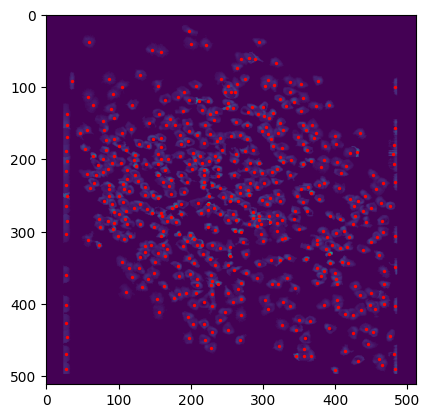

In [62]:
plt.figure()
plt.imshow(data.spatialFootprints[0].max(0).toarray().reshape(data.FOV_height, data.FOV_width, order='C'))
plt.scatter(data.centroids[0][:,1], data.centroids[0][:,0], color='r', s=2)